In [159]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.io import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import to_tensor

import warnings
warnings.simplefilter('ignore')

In [160]:
TRAIN_IMAGES_FODLER = '/kaggle/input/aaa-ml-2021/numbers_reading_train/'  # данные обучающей выборки
TEST_IMAGES_FODLER = '/kaggle/input/aaa-ml-2021/numbers_reading_test/'  # данные тестовой выборки
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  

TRAIN_FILE = '/kaggle/input/aaa-ml-2021/train_images.csv'  # данные с разметкой и названиеми файлов
TEST_FILE = '/kaggle/input/aaa-ml-2021/test_images.csv'  # данные с названиеми тестовых картинок файлов


MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

In [161]:
train_data = pd.read_csv(TRAIN_FILE)
train_data.head()

,image,number
0,4445.jpg,а729на126
1,5688.jpg,а365мт177
2,11820.jpg,х901рр123
3,10986.jpg,м215ех178
4,11192.jpg,к969то161


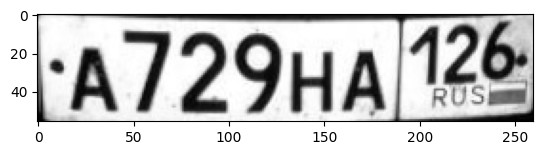

In [162]:
im = plt.imread(os.path.join(TRAIN_IMAGES_FODLER, '4445.jpg'))
plt.imshow(im, cmap='gray');

In [163]:
im.shape

(56, 260)

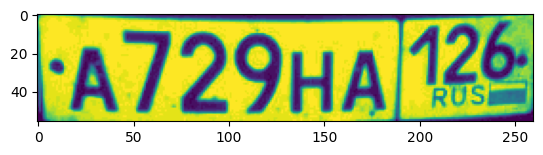

In [164]:
plt.imshow(read_numpy_gray(im)[..., 0] // 10)

In [165]:
def read_numpy_gray(im):
    im = torch.from_numpy(im)
    im = im.unsqueeze(0)
    im = im.repeat(3, 1, 1)
    im = im.permute(1, 2, 0)
    return im.numpy()

Посмотрим на картинку. Дорисуем линий разделяющие картинку на одинаковые участки:

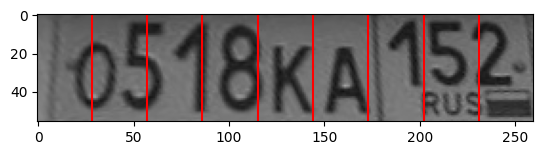

In [166]:
im = plt.imread(os.path.join(TRAIN_IMAGES_FODLER, '10008.jpg'))
plt.imshow(read_numpy_gray(im))

for i in range(1, 9):
    plt.plot([i * im.shape[1] // 9, i * im.shape[1] // 9], [0, 55], 'r');

Реализуем функцию, позволяющую отрисовать несколько картинок с разметкой в title:

In [167]:
def plot_samples(images, labels, nrows=3, ncols=3):

    f, axes = plt.subplots(nrows=nrows, ncols=nrows,)
    f.set_figheight(9)
    f.set_figwidth(9)

    for im_file, num, ax in zip(images, labels, axes.flatten()):
        im_path = os.path.join(TRAIN_IMAGES_FODLER, im_file)
        im = plt.imread(im_path)
        ax.imshow(im, cmap='gray')
        ax.set_title(num)
        ax.axis('off')

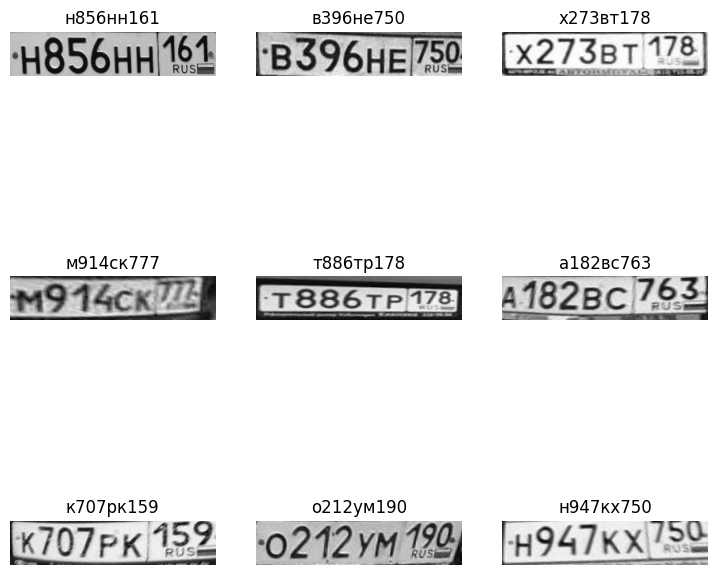

In [168]:
sample = train_data.sample(9, random_state=1)
plot_samples(sample['image'], sample['number']);

In [169]:
def plot_progress(lrs, train_losses, train_cers, train_accs, val_losses, val_cers, val_accs):
    clear_output(True)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)
    f.set_figheight(6)
    f.set_figwidth(20)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(val_losses, label='val loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_cers, label='train CER')
    ax2.plot(val_cers, label='val CER')
    ax2.plot(np.ones_like(train_accs), '--', label='100% accuracy')
    ax2.set_title('Char error rate')
    ax2.set_ylabel('CER')
    ax2.set_xlabel('Batch number')
    ax2.legend()
    
    ax3.plot(train_accs, label='train accuracy')
    ax3.plot(val_accs, label='val accuracy')
    ax3.plot(np.ones_like(train_accs), '--', label='100% accuracy')
    ax3.set_title('Accuracy')
    ax3.set_ylabel('Accuracy')
    ax3.set_xlabel('Batch number')
    ax3.legend()
    
    ax4.plot(lrs, label='learning rate')
    ax4.set_title('Learing rate')
    ax4.set_xlabel('Batch number')
    ax4.legend()

    plt.show()

In [170]:
letters = set(''.join(train_data.number))
n_letters = len(letters)

letter_index_map = {l: i for i, l in enumerate(letters)}
index_letter_map = {i: l for l, i in letter_index_map.items()}


In [171]:
index_letter_map

{0: '7',
 1: '8',
 2: '1',
 3: '3',
 4: '5',
 5: '4',
 6: 'т',
 7: 'с',
 8: '0',
 9: 'н',
 10: '2',
 11: '6',
 12: 'м',
 13: 'а',
 14: 'к',
 15: 'о',
 16: 'р',
 17: 'у',
 18: '9',
 19: 'х',
 20: 'в',
 21: 'е'}

In [172]:
letter_index_map = {
    '9': 0,
    '3': 1,
    'н': 2,
    '6': 3,
    'х': 4,
    '2': 5,
    '5': 6,
    'у': 7,
    'с': 8,
    'т': 9,
    '1': 10,
    'а': 11,
    '0': 12,
    'о': 12,
    '4': 13,
    'е': 14,
    '7': 15,
    'м': 16,
    '8': 17,
    'к': 18,
    'в': 19,
    'р': 20
}

index_letter_map = {
    0: '9',
    1: '3',
    2: 'н',
    3: '6',
    4: 'х',
    5: '2',
    6: '5',
    7: 'у',
    8: 'с',
    9: 'т',
    10: '1',
    11: 'а',
    12: '0',
    13: '4',
    14: 'е',
    15: '7',
    16: 'м',
    17: '8',
    18: 'к',
    19: 'в',
    20: 'р'
}

In [173]:
class PlateNumberDataset(Dataset):
    
    def __init__(self, image_folder, images, labels, mode='fit'):
        self.image_folder = image_folder
        self.images = images
        self.labels = labels
        self.mode = mode
        self.norm = T.Normalize(MEAN, STD)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = read_image(os.path.join(self.image_folder, self.images[idx]))
        image = image.repeat(3, 1, 1)
        
        image = self.norm(image.float() / 255.)
        labels = self.transform_labels(self.labels[idx])
        
        return image, labels
    
    @staticmethod
    def transform_labels(label_text):
        return torch.tensor([letter_index_map[l] for l in label_text])

Класс модели: 
1. ResNet18 без последних двух слоёв
2. Conv1d c выходом на размер словаря


In [174]:
from torchvision.models.vgg import vgg19

In [188]:
class PlateNumberReader(nn.Module):
    
    def __init__(self, pretrained=True):
        super(PlateNumberReader, self).__init__()
        self.resnet = nn.Sequential(*(list(vgg19(pretrained=pretrained).children())[:-2]))
        self.cnn = nn.Conv1d(in_channels=512, kernel_size=3, padding=1, out_channels=21)
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 9))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.resnet(x)
        x = self.pool(x)
        x = x.flatten(2)
        x = self.relu(x)
        x = self.cnn(x)
        return x

In [176]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data.image, train_data.number, test_size=0.1, 
)

train_dataset = PlateNumberDataset(image_folder=TRAIN_IMAGES_FODLER, images=X_train.values, labels=y_train.values)
val_dataset = PlateNumberDataset(image_folder=TRAIN_IMAGES_FODLER, images=X_val.values, labels=y_val.values, mode='predict')

train_sequence_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_sequence_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Сделаем расписание для скорости обучения: сначало будем плавно увеличивать от 0 до lr, потом постепенно уменьшать.

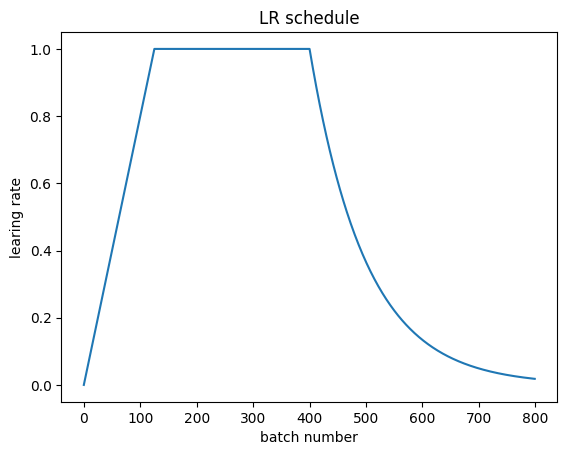

In [177]:
def schedule(step_number, breaking_step1=125, breaking_step2=400):
    
    if step_number < breaking_step1:
        return step_number / breaking_step1
    elif step_number < breaking_step2:
        return 1
    else:
        return (0.99 ** (step_number - breaking_step2))
    

n_steps = 800
plt.plot(np.arange(n_steps), [schedule(step) for step in np.arange(n_steps)])
plt.title('LR schedule')
plt.ylabel('learing rate')
plt.xlabel('batch number');

In [178]:
#train_data

In [60]:
model = PlateNumberReader()
model.to(DEVICE)

for i, param in enumerate(model.parameters()):
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
loss_func = nn.CrossEntropyLoss()

n_epochs = 30

losses = []
accs = []
accs_agg = []

val_losses = []
val_accs = []
val_accs_agg = []

lrs = []


for i in range(n_epochs):    
    for j, (x_train, y_train) in enumerate(train_sequence_dataloader):
        
        x_train = x_train.to(DEVICE)
        y_train = y_train.to(DEVICE)

        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = (torch.argmax(preds, dim=1) == y_train).float().mean()
        train_acc_agg = (torch.argmax(preds, dim=1) == y_train).all(dim=1).float().mean()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        model.eval()

        x_val, y_val = next(iter(val_sequence_dataloader))
        
        x_val = x_val.to(DEVICE)
        y_val = y_val.to(DEVICE)
        
        with torch.no_grad():
            val_preds = model(x_val)
            val_loss = loss_func(val_preds, y_val)
            val_acc = (torch.argmax(val_preds, dim=1) == y_val).float().mean()
            val_acc_agg = (torch.argmax(val_preds, dim=1) == y_val).all(dim=1).float().mean()

            losses.append(train_loss.item())
            accs.append(train_acc.item())
            accs_agg.append(train_acc_agg.item())

            val_losses.append(val_loss.item())
            val_accs.append(val_acc.item())
            val_accs_agg.append(val_acc_agg.item())

            plot_progress(lrs, losses, accs, accs_agg, val_losses, val_accs, val_accs_agg)


KeyboardInterrupt: 

## Работа на семинаре: аугментации данных

<img src="https://ucarecdn.com/420320c4-9a29-475b-8fa0-3951c6c3ca19/" style="width: 1200px;">

1) Посмотрите какие способы аугментации есть в torchvision.transforms, походят ли данные аугментации для нашей задачи? Бывают ли аугментации которые не подходят для одной задачи и подходят для другой?

In [179]:
from torchvision.transforms import v2

In [180]:
image_augmentations = v2.Compose([
    v2.RandomRotation(1),
    v2.GaussianBlur(13),
    v2.RandomPerspective(distortion_scale=0.1, p=0.3),
    v2.RandomSolarize(threshold=2.0),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

def augmented_numpy_gray(im):
    im = torch.from_numpy(im)
    im = im.unsqueeze(0)
    im = im.repeat(3, 1, 1)
    
    im = image_augmentations(im)
    
    im = im.permute(1, 2, 0)
    
    return im.numpy()

In [181]:
def plot_samples_with_augs(images, labels, transform=None, nrows=3, ncols=3):

    f, axes = plt.subplots(nrows=nrows, ncols=nrows,)
    f.set_figheight(9)
    f.set_figwidth(9)

    for im_file, num, ax in zip(images, labels, axes.flatten()):
        im_path = os.path.join(TRAIN_IMAGES_FODLER, im_file)
        im = plt.imread(im_path)
        
        if transform:
            im = transform(im)
            
        ax.imshow(im, cmap='gray')
        ax.set_title(num)
        ax.axis('off')

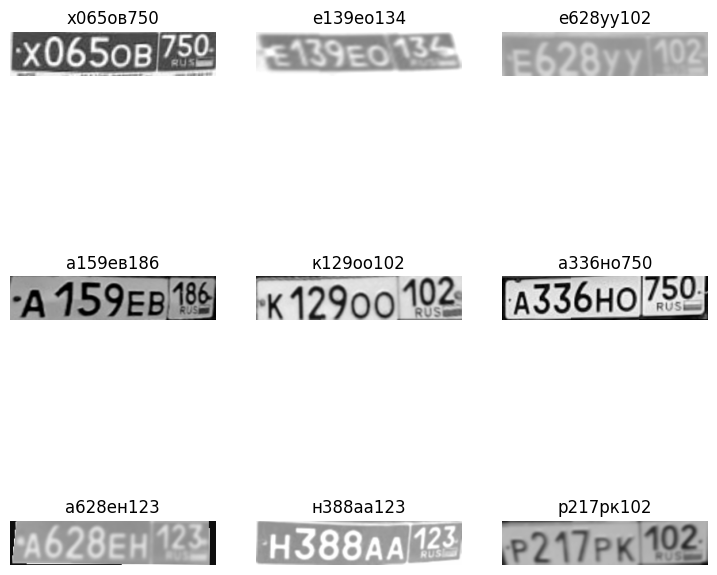

In [182]:
sample = train_data.sample(9)
plot_samples_with_augs(sample['image'], sample['number'], transform=augmented_numpy_gray);

In [183]:
class PlateNumberWithAugmentationsDataset(Dataset):
    
    def __init__(self, image_folder, images, labels, mode='fit'):
        self.image_folder = image_folder
        self.images = images
        self.labels = labels
        self.mode = mode
        self.norm = T.Normalize(MEAN, STD)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = read_image(os.path.join(self.image_folder, self.images[idx]))
        image = image.repeat(3, 1, 1)
        
        if self.mode =='fit':
            image = image_augmentations(image)
        
        image = self.norm(image.float() / 255.)
        labels = self.transform_labels(self.labels[idx])
        
        return image, labels
    
    @staticmethod
    def transform_labels(label_text):
        return torch.tensor([letter_index_map[l] for l in label_text])

In [184]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data.image, train_data.number, test_size=0.1, 
)

train_dataset = PlateNumberWithAugmentationsDataset(image_folder=TRAIN_IMAGES_FODLER, images=X_train.values, labels=y_train.values)
val_dataset = PlateNumberWithAugmentationsDataset(image_folder=TRAIN_IMAGES_FODLER, images=X_val.values, labels=y_val.values, mode='predict')

train_sequence_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_sequence_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

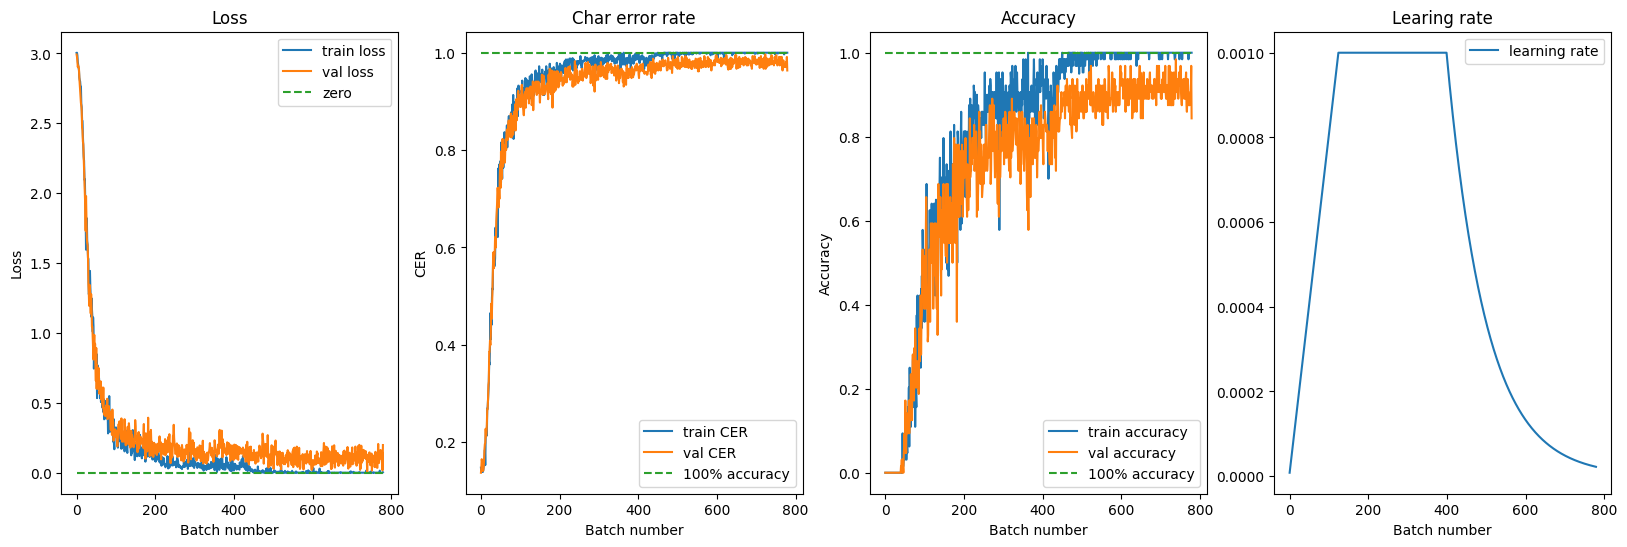

In [189]:
model = PlateNumberReader()
model.to(DEVICE)

for i, param in enumerate(model.parameters()):
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, schedule)
loss_func = nn.CrossEntropyLoss()

n_epochs = 30

losses = []
accs = []
accs_agg = []

val_losses = []
val_accs = []
val_accs_agg = []

lrs = []


for i in range(n_epochs):    
    for j, (x_train, y_train) in enumerate(train_sequence_dataloader):
        
        x_train = x_train.to(DEVICE)
        y_train = y_train.to(DEVICE)

        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = (torch.argmax(preds, dim=1) == y_train).float().mean()
        train_acc_agg = (torch.argmax(preds, dim=1) == y_train).all(dim=1).float().mean()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        model.eval()

        x_val, y_val = next(iter(val_sequence_dataloader))
        
        x_val = x_val.to(DEVICE)
        y_val = y_val.to(DEVICE)
        
        model.eval()
        
        with torch.no_grad():
            val_preds = model(x_val)
            val_loss = loss_func(val_preds, y_val)
            val_acc = (torch.argmax(val_preds, dim=1) == y_val).float().mean()
            val_acc_agg = (torch.argmax(val_preds, dim=1) == y_val).all(dim=1).float().mean()

            losses.append(train_loss.item())
            accs.append(train_acc.item())
            accs_agg.append(train_acc_agg.item())

            val_losses.append(val_loss.item())
            val_accs.append(val_acc.item())
            val_accs_agg.append(val_acc_agg.item())

            plot_progress(lrs, losses, accs, accs_agg, val_losses, val_accs, val_accs_agg)

Идеи для улучшения:
1. Больше аугментации!;
2. Синтез данных;
3. Другой backbone для получение признаков (возможно ResNet это overkill);
4. Другая голова для классификации;
5. Уменшить размер словаря – чтобы не путать "o" и 0;1) Посмотрите какие способы аугментации есть в torchvision.transforms, походят ли данные аугментации для нашей задачи? Бывают ли аугментации которые не подходят для одной задачи и подходят для другой?
6. Регуляризация.

Домашнее задание:
* Пробить порого accuracy > 0.95

In [190]:
test = pd.read_csv(TEST_FILE)

In [191]:
test.values.flatten()

array(['11907.jpg', '1917.jpg', '3675.jpg', '164.jpg', '2230.jpg',
       '124.jpg', '12904.jpg', '9205.jpg', '12433.jpg', '13157.jpg',
       '10431.jpg', '12823.jpg', '13272.jpg', '13463.jpg', '11959.jpg',
       '7201.jpg', '740.jpg', '10823.jpg', '12577.jpg', '12333.jpg',
       '8404.jpg', '10022.jpg', '11373.jpg', '10487.jpg', '10717.jpg',
       '2465.jpg', '6082.jpg', '10536.jpg', '1652.jpg', '3187.jpg',
       '4876.jpg', '32.jpg', '4540.jpg', '10280.jpg', '4267.jpg',
       '10946.jpg', '13289.jpg', '12076.jpg', '5664.jpg', '10390.jpg',
       '13850.jpg', '13397.jpg', '10285.jpg', '11486.jpg', '10012.jpg',
       '340.jpg', '12740.jpg', '3346.jpg', '12891.jpg', '12278.jpg',
       '755.jpg', '11684.jpg', '4716.jpg', '10691.jpg', '4721.jpg',
       '2641.jpg', '12883.jpg', '3755.jpg', '9949.jpg', '3963.jpg',
       '5776.jpg', '5963.jpg', '12731.jpg', '11333.jpg', '10883.jpg',
       '2497.jpg', '2063.jpg', '10876.jpg', '12460.jpg', '13691.jpg',
       '3271.jpg', '433.jpg', 

In [192]:
test_dataset = PlateNumberDataset(image_folder=TEST_IMAGES_FODLER, images=test.values.flatten(), labels=['0'] * test.size, mode='predict')

In [193]:
model.eval()

PlateNumberReader(
  (resnet): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [195]:
res = []

In [196]:
for x, y in test_dataset:
    pred = model(x.reshape(1, 3, 56, 260).to(DEVICE))
    pred = pred.argmax(dim=1).flatten().tolist()
    pred = [index_letter_map[i] for i in pred]

    if pred[0] == '0':
        pred[0] = 'о'
    if pred[4] == '0':
        pred[4] = 'о'
    if pred[5] == '0':
        pred[5] = 'о'
    
    res.append(''.join(pred))

In [197]:
test['plate_number'] = pd.Series(res)

In [198]:
test.to_csv('solution.csv', index=False, header=['image', 'plate_number'])

In [167]:
pred = model(x.reshape(1, 3, 56, 260).to(DEVICE))
pred = pred.argmax(dim=1).flatten().tolist()
pred = [index_letter_map[i] for i in pred]

if pred[0] == '0':
    pred[0] = 'о'
if pred[4] == '0':
    pred[4] = 'о'
if pred[5] == '0':
    pred[5] = 'о'

In [168]:
pred

['у', '2', '0', '1', 'х', 'с', '1', '7', '4']